<a href="https://colab.research.google.com/github/brahma2024/Deep-Implicit-Layers/blob/main/Ch2_2_1_AdjointMethod_NonLinearSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Notebook
**1. Compare runtime complexity for solving a linear system of euqation between**
  - `Solving the linear system of equation by doing a Matrix Inversion`
    e.g. For a linear system of equation given by
      $𝑨 ⋅ \vec{v} = \vec{b}$,
      
 where $\vec{v} ϵ  ℝⁿ$ \begin{pmatrix} 1 & 2 & 3 .. n \end{pmatrix}

      solving through matrix inversion would require solving the following way
      
      $\vec{v} = 𝑨\^{-1} ⋅ \vec{b}$

  - `Directly Solving a System of linear equation using linear solvers like LU decomposition etc` is more efficient



**2. Different methods for calculating sensitivities of Non-Linear Equation**

**3. Adjoint Sensitivites of Non-Linear system of Equations**

**4. Adjoint state method for an ODE**

# Solving a Matrix Inverse:

- **Understanding cost of solving using**
  - `*[Non Prefered]* Direct Matrix Inversion`
  - `*[Prefered]* Solving the system directly using techniques like Gaussian elimination, LU decomposition, or other numerical methods`

- `For detailed explanation`,
  - Ask chatGPT the question: explain this with example - "The matrix 𝐴−1 suggests that we are solving a system of linear equations rather than directly inverting the matrix, which is more computationally efficient."

Here are the reasons:
- `Drawbacks of Direct Matrix Inversion:`
  - Computing the inverse 𝐴−1 directly is computationally expensive, especially for large matrices. The time complexity for inverting a matrix is approximately O(n^3).
  - Direct inversion can also lead to numerical instability, especially if 𝐴 is close to being singular (i.e., it's not easily invertible due to small determinants).

- `Benefits of Solving the system of equations directly using techniques like LU decomposition`
  - Solving the linear system Ax=b directly is computationally more efficient, typically having a complexity of 𝑂(𝑛^2) or slightly higher depending on the method used. It's also more numerically stable compared to inverting 𝐴 first.

In [8]:
import numpy as np
import time
import torch
from torch.autograd.functional import jacobian
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
# Define Functions to Measure Time for Matrix Inversion and Solving a System

def matrix_inversion(A, b):
    # Measure the time taken to invert the matrix
    start_time = time.time()
    A_inv = np.linalg.inv(A)
    x_direct = np.dot(A_inv, b)
    end_time = time.time()

    return x_direct, end_time - start_time

def solve_system(A, b):
    # Measure the time taken to solve the linear system
    start_time = time.time()
    x_solve = np.linalg.solve(A, b)
    end_time = time.time()

    return x_solve, end_time - start_time


In [3]:
# Comparing output from the 2 Methods: Direct Matrix Inversion and Solving the system of Equations directly

# Generate a random n x n matrix
n = 5

# Create a random n x n matrix and an n x 1 vector
A = np.random.rand(n, n)
b = np.random.rand(n)

# Method 1: Direct inversion (not recommended for large matrices)
x_direct, _ = matrix_inversion(A, b)

# Method 2: Solving the system directly (preferred method)
x_solve, _ = solve_system(A, b)

print("Solution using direct inversion:", x_direct, A.shape)
print("Solution using direct solving:", x_solve)

Solution using direct inversion: [-0.33259012  0.20809408  1.02050349  0.53425373 -0.68005155] (5, 5)
Solution using direct solving: [-0.33259012  0.20809408  1.02050349  0.53425373 -0.68005155]


In [4]:
# Run the experiment for Different Matrix Sizes

# Define the matrix sizes to test
matrix_sizes = [10, 50, 100, 200, 500, 1000, 2000]

# Lists to store the times
inversion_times = []
solve_times = []

# Measure time for each matrix size
for n in matrix_sizes:
  # Create a random n x n matrix and an n x 1 vector
  A = np.random.rand(n, n)
  b = np.random.rand(n)
  _, inversion_time = matrix_inversion(A, b)
  _, solve_time = solve_system(A, b)

  inversion_times.append(inversion_time)
  solve_times.append(solve_time)

  print(f"Matrix size {n}x{n}: Inversion time = {inversion_time:.6f} seconds, Solve time = {solve_time:.6f} seconds")


Matrix size 10x10: Inversion time = 0.000146 seconds, Solve time = 0.000046 seconds
Matrix size 50x50: Inversion time = 0.000373 seconds, Solve time = 0.000112 seconds
Matrix size 100x100: Inversion time = 0.006233 seconds, Solve time = 0.001454 seconds
Matrix size 200x200: Inversion time = 0.007998 seconds, Solve time = 0.008825 seconds
Matrix size 500x500: Inversion time = 0.059033 seconds, Solve time = 0.031278 seconds
Matrix size 1000x1000: Inversion time = 0.248341 seconds, Solve time = 0.096367 seconds
Matrix size 2000x2000: Inversion time = 1.691448 seconds, Solve time = 0.774159 seconds


# Interpretation of Results

- **Expected Observation:** As the matrix size n increases, the time taken to compute the matrix inverse should grow more rapidly compared to the time taken to solve the system of equations. This will confirm the *𝑂(𝑛^3)* time complexity of matrix inversion versus the typically *𝑂(𝑛^2)* or slightly higher complexity for solving linear systems.

- **Plot:** The plot should visually demonstrate that as n increases, the inversion time increases more steeply compared to the time taken to solve the system.


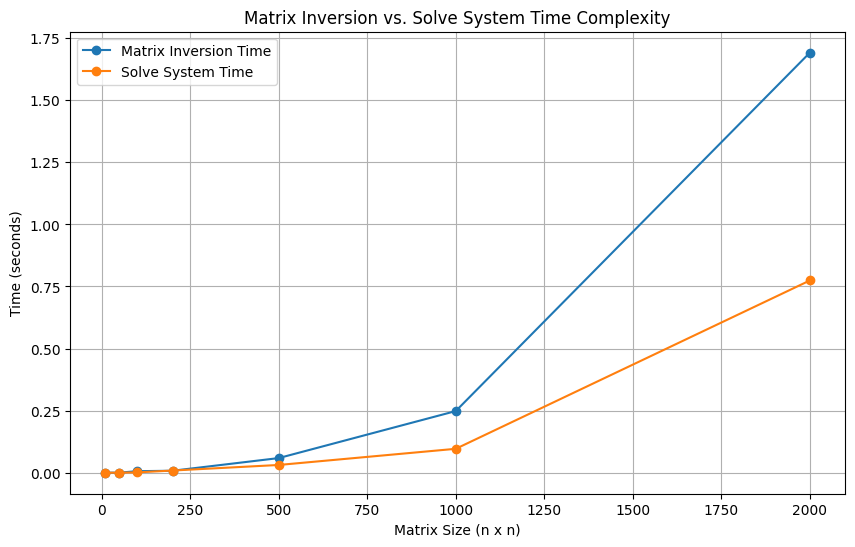

In [5]:
# Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, inversion_times, label='Matrix Inversion Time', marker='o')
plt.plot(matrix_sizes, solve_times, label='Solve System Time', marker='o')
plt.xlabel('Matrix Size (n x n)')
plt.ylabel('Time (seconds)')
plt.title('Matrix Inversion vs. Solve System Time Complexity')
plt.legend()
plt.grid(True)
plt.show()


# Sensitivity methods for Non-Linear Equations

**Objective:** Showcases different sensitity methods for gradient propagation over the solution to non-linear equations.

**Setup:**
- Assume the residual function
  
  $r(u, θ) = {u}^ 2 - sin(θ)$

  is solved for $u$ by a root finding method. (e.g. a Newton-Raphson or Andersson Acceleration method)

  The resulting solution $u^*$ associated with $\theta^*$ enters a loss functional

  $J(u) = u^2$

  We now seek gradient of this scalar-valued loss-function $J(u, \theta)$ w.r.t. $θ$
  
    $𝑑J/𝑑\theta$      
    
    e.g. for usage in gradient based optimization

  For that we assume we have a (hypothetical) function f that maps from $θ$ to $u$, i.e. it solves the root finding problem.

  
--

  **Finite Differences:**

  This is the most Naive appraoch, where
  
  $𝑑J/𝑑\theta ≈ ( J ( f(θ^* + ε)) - J(F(θ^*)) / ε$


--

  **Forward Sensitivities**
  
  (essentially calculating the full jacobian in the forward pass) - $JVP$

  1. Solve classical problem
      $u^* = f(\theta^*)$

  2. Obtain solution sensititivities (all evaluated at $u^*$  and $\theta^*$)

  $𝑑u/𝑑θ = (∂r/∂u)^{-1} * ∂r/∂θ$

  3. Obtain loss sensititivities ( all evaluated at $u^*$ and $u^*$)

  $𝑑J/𝑑θ = ∂J/∂u * 𝑑u/𝑑θ$


--

**Adjoint Method**

  1. Solve classical problem

  $u^* = f(θ^*)$

  2. Obtain adjoint variable (all evalutaed at $u^*$ and $θ^*$

  $λ = (∂r/∂u)^{-1} * ∂J/∂u$

  3. Obtain loss sensitivities ( all evaluated at $u^*$ and $θ^*$

  $𝑑J/𝑑θ = λ * ∂r/∂θ$

In [49]:
# define the non-linear function determining the dynamics of the system
def dynamic_function(u, theta):
  # theta is the parameter vector
  # u is some input vector, implicitly dependent on parameters theta
  return u**2 - np.sin(theta)

def del_df_del_u(u, theta):
  # partial derivative (jacobian) of dynamic_function w.r.t. u
  return 2.0*u

def del_df_del_theta(u, theta):
  # jacobian of the dynamic_function w.r.t. theta
  return np.cos(theta)

# Find the root of the non-linear dynamic function
def obtain_root(theta):
  u_0 = 1.0 # Initial value.
  root_finding_result = optimize.root_scalar(
      f=lambda u: dynamic_function(u, theta=theta),
      x0=u_0,
      fprime=lambda u: del_df_del_u(u, theta=theta),
  )

  assert root_finding_result.converged
  return root_finding_result.root


def loss_functional(u):
  # define the scalar-valued loss functional J
  return u**2

def del_J_del_u(u):
  # calculate the partial derivative of scalar-valued loss functional J w.r.t. u
  return 2*u

evaluation_point = 1.0
u_at_evaluation_point = obtain_root(evaluation_point)
J_at_evaluation_point = loss_functional(u_at_evaluation_point)
print(f'{u_at_evaluation_point=:.10f}')
print(f'{J_at_evaluation_point=:.10f}')

u_at_evaluation_point=0.9173172760
J_at_evaluation_point=0.8414709848


In [66]:
### Finite Differences
epsilon = 1.0e-6

# loss sensitivity using finite difference method
d_J_d_theta_finite_differences = (
    loss_functional(obtain_root(evaluation_point + epsilon))
    -
    loss_functional(obtain_root(evaluation_point))
) / epsilon

print(f'Finite Differences Method to calculate | {d_J_d_theta_finite_differences=:.16f}')

Finite Differences Method to calculate | d_J_d_theta_finite_differences=0.5403018851213304


In [68]:
### Forward sensitivites
'''
1. Solve classical problem  𝑢∗=𝑓(𝜃∗)

2. Obtain solution sensititivities (all evaluated at  𝑢∗  and  𝜃∗ )
  𝑑𝑢/𝑑θ=(∂𝑟/∂𝑢)−1∗∂𝑟/∂θ

3. Obtain loss sensititivities ( all evaluated at  𝑢∗  and  𝑢∗ )
  𝑑𝐽/𝑑θ=∂𝐽/∂𝑢∗𝑑𝑢/𝑑θ
'''

u_classical = obtain_root(evaluation_point)
# del_u_del_theta
solution_sensitivity = (
    (1.0 / del_df_del_u(u_classical, evaluation_point)) * (del_df_del_theta(u_classical, evaluation_point))
)

# loss sensitivity using forward sensitivites method
d_J_d_theta_forward = (
    del_J_del_u(u_classical) * solution_sensitivity
)

print(f'Forward Sensitivity Approach to calculate | {d_J_d_theta_forward=:.16f}')

Forward Sensitivity Approach to calculate | d_J_d_theta_forward=0.5403023058681398


In [67]:
### Adjoint Sensitivity
'''
Adjoint Method

1. Solve classical problem
  𝑢∗=𝑓(θ∗)

2. Obtain adjoint variable (all evalutaed at  𝑢∗  and  θ∗
  λ=(∂𝑟/∂𝑢)−1∗∂𝐽/∂𝑢

3. Obtain loss sensitivities ( all evaluated at  𝑢∗  and  θ∗
  𝑑𝐽/𝑑θ=λ∗∂𝑟/∂θ
'''

u_classical = obtain_root(evaluation_point)

# adjoint variable
adjoint_variable = (1.0 / del_df_del_u(u_classical, evaluation_point)) * (del_J_del_u(u_classical))

# loss sensitivity using adjoint method
d_J_d_theta_adjoint = adjoint_variable * del_df_del_theta(u_classical, evaluation_point)

print(f'Adjoint Sensitivity Approach to calculate | {d_J_d_theta_adjoint=:.16f}')

Adjoint Sensitivity Approach to calculate | d_J_d_theta_adjoint=0.5403023058681398


# Adjoint Sensitivities of Non-Linear System of Equations